The following is the notebook of code written by H. Passmore for the development of the Inferential Statistics Assignment for Capstone 1: Amazon Book Reviews & Ratings Predictor. 

# Inferential Statistics for Capstone 1
_Amazon Book Reviews & Ratings Predictor_

_Inferential Statisitcs and Machine Learning Code_
***

### Below is the code for statistical analyses associated with the inferential statistics report.

In [1]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import norm
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm

# Build figures inline
%matplotlib inline

In [2]:
# Setup Pandas  
pd.set_option('display.width', 350)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("talk")

In [4]:
# bring the reviews and word counts dataframe into workspace
# import pickle
# load the pickled  DataFrame of Science Textbook Reviews from hard drive in 'rb' mode
import pickle
with open('reviews_counts.pickle','rb') as f:
    sci_revs = pickle.load(f)

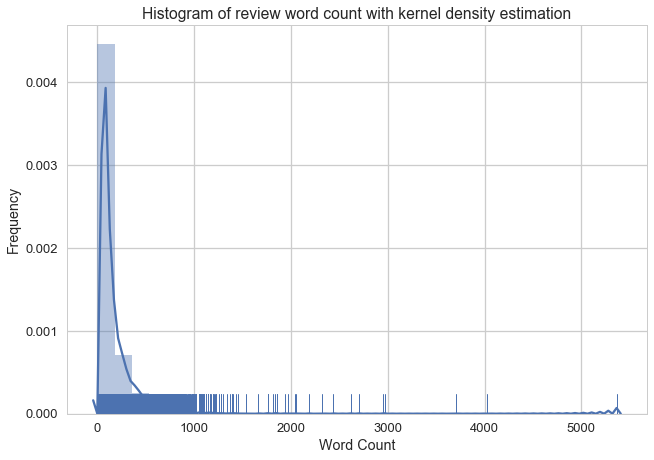

In [5]:
# view a histogram of word counts
sns.distplot(sci_revs.word_count, bins= 30, kde=True, rug=True);
plt.title('Histogram of review word count with kernel density estimation');
plt.xlabel('Word Count');
plt.ylabel('Frequency');

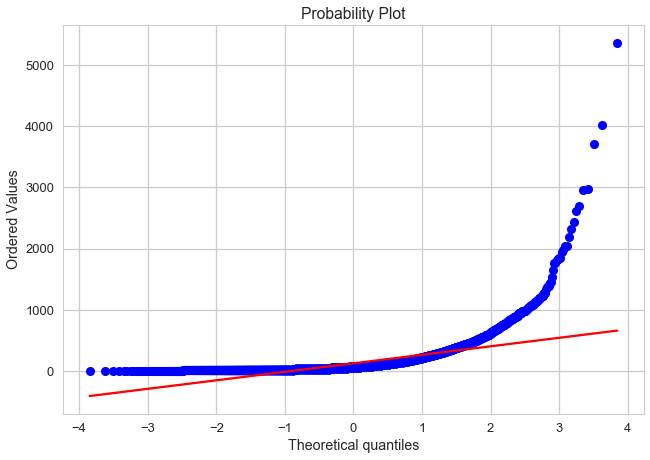

In [6]:
# check normality with Q-Q plot
scipy.stats.probplot(sci_revs.word_count, dist='norm', fit=True, plot=plt);

In [7]:
small_df = pd.DataFrame(sci_revs[['asin','overall','reviewText', 'reviewTime', 'reviewerID', 'summary', 'word_count', 'longest',
                                 'char_length']])
small_df.head(2)

,asin,overall,reviewText,reviewTime,reviewerID,summary,word_count,longest,char_length
0,0006531644,4,This is a good book for the science nerd and t...,"07 9, 2012",A2T1HLL9IPHEP1,A Great Read,33,12,185
1,0006531644,5,"If you're a biology/genetics enthusiast, this ...","05 1, 2013",A1GP2V4NYRK36P,Very interesting reading,39,16,228


In [8]:
# create new five_not5 variable. Will convert to 0/1 for model fitting.
small_df['five_not5'] = np.where(small_df['overall']> 4, 'five' , 'not5')
small_df.head(2)

,asin,overall,reviewText,reviewTime,reviewerID,summary,word_count,longest,char_length,five_not5
0,0006531644,4,This is a good book for the science nerd and t...,"07 9, 2012",A2T1HLL9IPHEP1,A Great Read,33,12,185,not5
1,0006531644,5,"If you're a biology/genetics enthusiast, this ...","05 1, 2013",A1GP2V4NYRK36P,Very interesting reading,39,16,228,five


In [9]:
# The number of words per review are count data and predictably non-normal
# Log transform 'word_count' to improve normality
small_df = small_df.assign(log_count = lambda x: np.log(x.word_count))

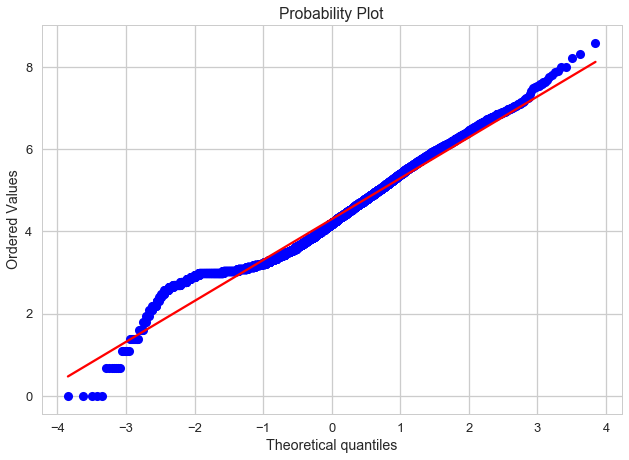

In [10]:
# check normality again with Q-Q plot
scipy.stats.probplot(small_df.log_count, dist='norm', fit=True, plot=plt);

In [11]:
# groupby five_not5 column
groupby_rating = small_df['log_count'].groupby(small_df['five_not5'])
groupby_rating

In [12]:
# means for five-star vs other ratings: higher mean word count for other ratings
groupby_rating.mean()

five_not5
five    4.192534
not5    4.507112
Name: log_count, dtype: float64

In [13]:
# get descriptive stats of two categories: five vs not5
groupby_rating.describe()

,count,mean,std,min,25%,50%,75%,max
five_not5,,,,,,,,
five,7662.0,4.192534,0.963172,0.0,3.401197,4.060443,4.836282,8.587465
not5,3884.0,4.507112,1.060874,0.0,3.610918,4.477337,5.299564,8.300777


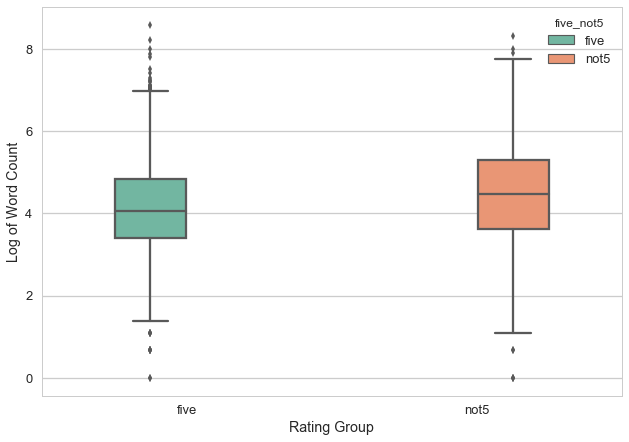

In [14]:
# create boxplots to compare means and quartiles for ratings categories (five, not5)
sns.boxplot(x='five_not5', y='log_count', data=small_df, hue='five_not5', order=['five', 'not5'], 
            hue_order=['five', 'not5'], palette='Set2', width=0.5);
plt.xlabel('Rating Group');
plt.ylabel('Log of Word Count');

In [15]:
# create arrays for t-test
five_count = small_df.log_count[small_df.five_not5 == 'five']
not5_count = small_df.log_count[small_df.five_not5 == 'not5']

In [16]:
# perform hypothesis test with two-sided independent t-test for unequal variances
tstat, p_value = scipy.stats.ttest_ind(not5_count, five_count, equal_var=False)
print('Tests statistic', '{0:0.3f}'.format(tstat))
print('P-value of test', '{0:0.3f}'.format(p_value))
if p_value < 0.05:
    print('Reject the Null hypothesis: There is a difference between word counts for 5-star and other rated reviews.')
else:
    print('Fail to reject the Null: There is no difference between word counts for 5-star and other rated reviews.')

Tests statistic 15.520
P-value of test 0.000
Reject the Null hypothesis: There is a difference between word counts for 5-star and other rated reviews.


## For books reviewed by more than 10 reviewers how are mean ratings distributed?

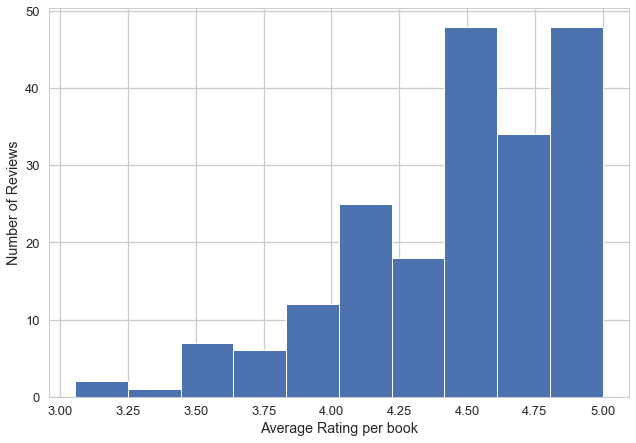

In [17]:
grp = small_df.groupby('asin')
counts = grp.asin.count()  # number of reviews per book
means = grp.overall.mean()     # average rating for each book

means[counts > 10].hist(bins=10, edgecolor='w', lw=1);
plt.xlabel("Average Rating per book");
plt.ylabel("Number of Reviews");
# for books (asin) reviewed by more than 10 reviewers the mean ratings are most frequently 4+

## Use NLTK to tokenize, explore word frequencies, and quantify ALL CAPS in reviews

In [18]:
# set up nltk
import nltk
#nltk.download('punkt')

In [19]:
# download stopwords
#nltk.download('stopwords')

In [20]:
# Import regular expressions and other NLTK tools
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [21]:
# create dataframe with just book codes, ratings, reviews and summaries
reviews = pd.DataFrame(small_df[['asin','overall','reviewText', 'summary', 'five_not5']])
reviews.head(2)

,asin,overall,reviewText,summary,five_not5
0,0006531644,4,This is a good book for the science nerd and t...,A Great Read,not5
1,0006531644,5,"If you're a biology/genetics enthusiast, this ...",Very interesting reading,five


In [22]:
# apply word_tokenize and create new column: 'tokenized_text'
reviews['tokenized_text'] = reviews['reviewText'].apply(word_tokenize)

In [23]:
# count the number of tokens in the list of strings in 'tokenized_text'
reviews['token_count'] = reviews.tokenized_text.str.len()

In [24]:
reviews.head(3)

,asin,overall,reviewText,summary,five_not5,tokenized_text,token_count
0,0006531644,4,This is a good book for the science nerd and t...,A Great Read,not5,"[This, is, a, good, book, for, the, science, n...",37
1,0006531644,5,"If you're a biology/genetics enthusiast, this ...",Very interesting reading,five,"[If, you, 're, a, biology/genetics, enthusiast...",45
2,0007116837,4,I bought this for my daughter who borrowed all...,Another McCourt,not5,"[I, bought, this, for, my, daughter, who, borr...",61


In [25]:
# translate examples of word frequency analysis to pandas dataframe environment
# need to get all words into one list called tokens, remove stopwords and get frequency count
text = reviews['reviewText'].str.lower().str.cat(sep='')

In [26]:
# import RegexpTokenizer from nltk.tokenize
from nltk.tokenize import RegexpTokenizer

# Create tokenizer
tokenizer = RegexpTokenizer('\w+')

In [27]:
# Create tokens
tokens = tokenizer.tokenize(text)
tokens[:8]

['this', 'is', 'a', 'good', 'book', 'for', 'the', 'science']

In [28]:
# Get English stopwords and print some of them
sw = nltk.corpus.stopwords.words('english')
sw[:5]

['i', 'me', 'my', 'myself', 'we']

In [29]:
# initialize a new list
clean_tokens = []
# add to clean_tokens all tokens that are in tokens but not in sw
for token in tokens:
    if token not in sw:
        clean_tokens.append(token)
        
# print a few words to check
clean_tokens[:8]

['good', 'book', 'science', 'nerd', 'non', 'science', 'alike', 'lots']

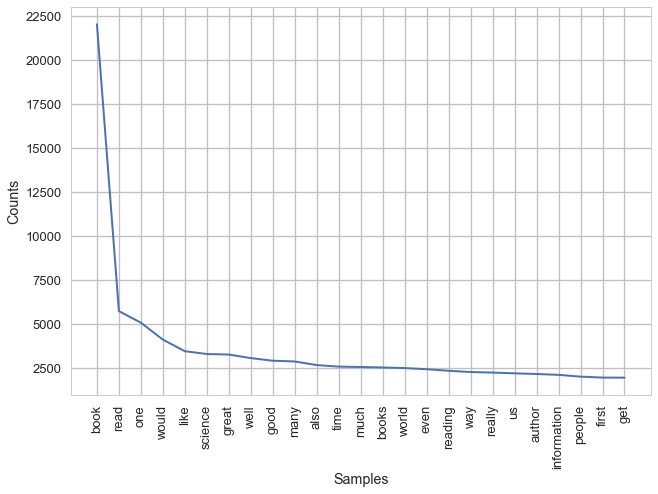

In [30]:
# Create freq dist of tokens and plot
freqdist1 = nltk.FreqDist(clean_tokens)
freqdist1.plot(25)

Word frequency graph reveals that normalization of tokens is not complete. Words still could be stemmed and lemmatized to reduce redundant words like 'book' and 'books' from appearing separately. We will add this step to the Machine Learning pipeline.

### Compare percentage of all caps words in five-star vs 1 to 4-star reviews

In [31]:
# can we count ALL CAPS in tokenized_text?
# use regular expressions to find all words with A-Z caps
reviews['caps'] = reviews.reviewText.str.findall(r'\b[A-Z]{1,}\b')

In [32]:
# count the number of ALL CAPS tokens in the list of strings in 'caps'
reviews['caps_count'] = reviews.caps.str.len()
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11546 entries, 0 to 11545
Data columns (total 9 columns):
asin              11546 non-null object
overall           11546 non-null int64
reviewText        11546 non-null object
summary           11546 non-null object
five_not5         11546 non-null object
tokenized_text    11546 non-null object
token_count       11546 non-null int64
caps              11546 non-null object
caps_count        11546 non-null int64
dtypes: int64(3), object(6)
memory usage: 811.9+ KB


In [33]:
# calculate proportion of words per review in ALL CAPS
reviews['pct_caps'] = ((reviews['caps_count']+0.001)/(reviews['token_count']))*100
reviews.head()

,asin,overall,reviewText,summary,five_not5,tokenized_text,token_count,caps,caps_count,pct_caps
0,0006531644,4,This is a good book for the science nerd and t...,A Great Read,not5,"[This, is, a, good, book, for, the, science, n...",37,[],0,0.002703
1,0006531644,5,"If you're a biology/genetics enthusiast, this ...",Very interesting reading,five,"[If, you, 're, a, biology/genetics, enthusiast...",45,[I],1,2.224444
2,0007116837,4,I bought this for my daughter who borrowed all...,Another McCourt,not5,"[I, bought, this, for, my, daughter, who, borr...",61,"[I, I]",2,3.280328
3,0007116837,4,This book was recommended by a tour guide in I...,A Monk Swimming,not5,"[This, book, was, recommended, by, a, tour, gu...",26,[],0,0.003846
4,0028255267,5,Our school recently upgraded to this chemistry...,very thorough chem book...,five,"[Our, school, recently, upgraded, to, this, ch...",118,"[SAT, II, SAT, II]",4,3.390678


In [34]:
reviews.shape

(11546, 10)

In [35]:
type(reviews)

pandas.core.frame.DataFrame

In [36]:
reviews.columns

Index(['asin', 'overall', 'reviewText', 'summary', 'five_not5', 'tokenized_text', 'token_count', 'caps', 'caps_count', 'pct_caps'], dtype='object')

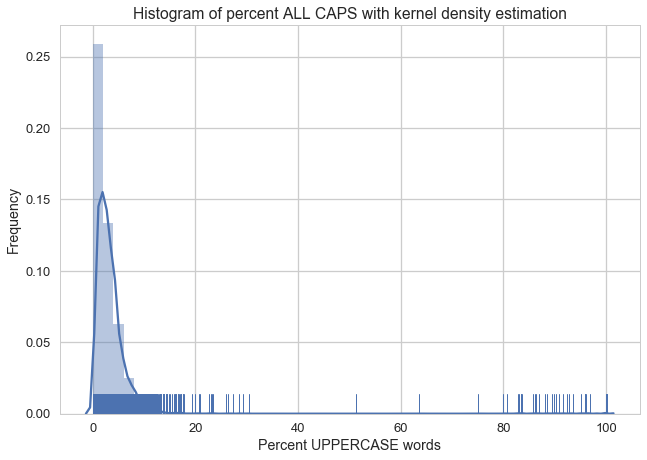

In [37]:
# view a histogram of ALL CAPS counts
sns.distplot(reviews.pct_caps, bins= 50, kde=True, rug=True);
plt.title('Histogram of percent ALL CAPS with kernel density estimation');
plt.xlabel('Percent UPPERCASE words');
plt.ylabel('Frequency');

In [38]:
# The percent of words written in ALL CAPS per review is skewed
# Log transform 'pct_caps' to improve normality
reviews = reviews.assign(log_pct = lambda x: np.sqrt(x.pct_caps))

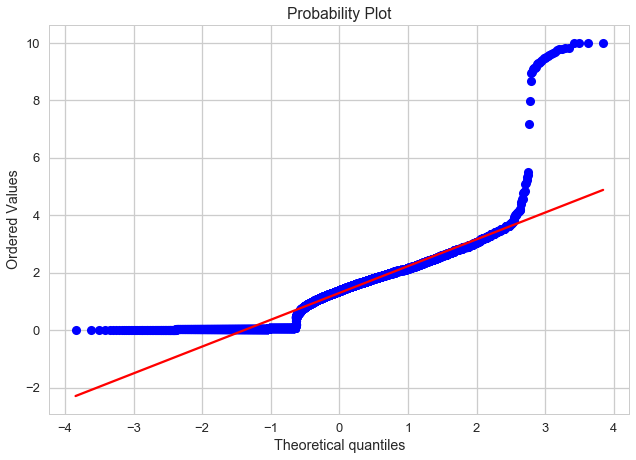

In [39]:
# check normality with Q-Q plot
scipy.stats.probplot(reviews.log_pct, dist='norm', fit=True, plot=plt);

__Percent ALL CAPS data are skewed__ Because the raw percent all caps data are bimodal transformations to make the data more normally distributed are not likely. Q-Q plots for both log and square-root transformed percents indicate that the transformed data are not normally distributed.

In [40]:
# groupby five_not5 column
groupby_pct = reviews['pct_caps'].groupby(reviews['five_not5'])

# Descriptive stats for percent all caps by five vs not5
groupby_pct.describe()

,count,mean,std,min,25%,50%,75%,max
five_not5,,,,,,,,
five,7662.0,2.730162,5.781887,0.000159,0.004348,1.887421,3.731355,100.1
not5,3884.0,2.575424,4.093586,0.000125,0.525207,1.899130,3.643069,100.1


In [41]:
# create arrays for t-test
five_CAPS = reviews.pct_caps[reviews.five_not5 == 'five']
not5_CAPS = reviews.pct_caps[reviews.five_not5 == 'not5']

# perform hypothesis test with two-sided independent t-test for unequal variances
tstat, p_value = scipy.stats.ttest_ind(not5_CAPS, five_CAPS, equal_var=False)
print('Tests statistic', '{0:0.3f}'.format(tstat))
print('P-value of test', '{0:0.3f}'.format(p_value))
if p_value < 0.05:
    print('Reject the Null hypothesis: There is a difference between word counts for 5-star and other rated reviews.')
else:
    print('Fail to reject the Null: There is no difference between word counts for 5-star and other rated reviews.')

Tests statistic -1.661
P-value of test 0.097
Fail to reject the Null: There is no difference between word counts for 5-star and other rated reviews.


__INTERPRETATION:__ A two-sided independent t-test for unequal variances on the untransformed percentage of UPPERCASE words is not an ideal analysis. Because the data are bimodal and skewed (very many low percents and a few high percents) there are no good transformations for simple statistics. However, based on the descriptive statistics and t-test results it is likely that the high percentages are a mixture of five-star and other reviews (t = -1.67, p = 0.097).

In [42]:
# let's look at only the higher perentages
five_high = [x for x in five_CAPS if x>=25]
not5_high = [x for x in not5_CAPS if x>=25]
print('Percent ALL CAPS Five-star sample size is', len(five_high))
print('Percent ALL CAPS 1 to 4-star sample size is', len(not5_high))
print('Percent ALL CAPS Five-star mean percent is', np.mean(five_high))
print('Percent ALL CAPS 1 to 4-star mean percent is', np.mean(not5_high))

Percent ALL CAPS Five-star sample size is 32
Percent ALL CAPS 1 to 4-star sample size is 7
Percent ALL CAPS Five-star mean percent is 79.2906963334
Percent ALL CAPS 1 to 4-star mean percent is 75.6905994678


In [43]:
# perform hypothesis test with two-sided independent t-test for unequal variances
tstat, p_value = scipy.stats.ttest_ind(not5_high, five_high, equal_var=False)
print('Tests statistic', '{0:0.3f}'.format(tstat))
print('P-value of test', '{0:0.3f}'.format(p_value))
if p_value < 0.05:
    print('Reject the Null hypothesis: There is a difference between word counts for 5-star and other rated reviews.')
else:
    print('Fail to reject the Null: There is no difference between word counts for 5-star and other rated reviews.')

Tests statistic -0.327
P-value of test 0.752
Fail to reject the Null: There is no difference between word counts for 5-star and other rated reviews.


__Interpretation:__ There are many small values of percent UPPERCASE words for both ratings groups. The data are not normal, but the means are very similar and there is a lot of variation when considering all the reviews. I subsetted the arrays of percentages to only look at higher precentages - ignoring reviews where the UPPERCASE words were probably ('I' and 'A' with normal frequencies). When I considered reviews with 25% or more UPPERCASE words there were 32 5-star reviews and only 7 4-stars or fewer reviews. The means were 79% and 75%, respectively. The statistical comparison betwen these two groups indicates there is no differences between the five-star and 1 to 4-star percentages of UPPERCASE words. This analysis was indicative of other sub-groups I considered. The t-test was significant when I set the cut-off for percentages at 5% and larger, however the means were 9% and 8%. This level of UPPERCASE word percentages is well within the range of expected for normal sentences written without ALL CAPS for emphasis.

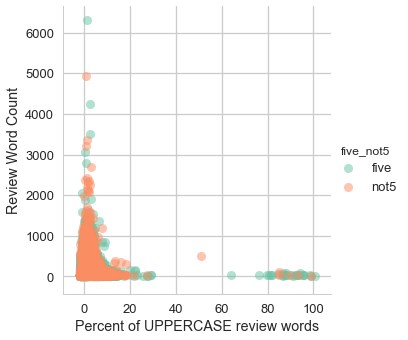

In [44]:
# word count and percent uppercase to see if we can see patterns
# with seaborn plot scatter plot of review character count against longest word length colored by 'overall'
sns.lmplot(x='pct_caps', y='token_count', hue='five_not5', hue_order=['five', 'not5'], palette='Set2', 
           data=reviews, fit_reg=False, x_jitter=2, scatter_kws={'alpha':0.5});
plt.xlabel('Percent of UPPERCASE review words');
plt.ylabel('Review Word Count');

### Prepare dataframe for machine learning algorithms

In [46]:
# convert label to a numerical variable
reviews['rating_cat'] = reviews.five_not5.map({'not5':0, 'five':1})

In [47]:
# simplify dataframe for ML steps
book_revs = pd.DataFrame(reviews[['asin','overall','reviewText', 'summary', 'five_not5', 'rating_cat', 'token_count',
                                 'caps_count', 'pct_caps']])
book_revs.head(2)

,asin,overall,reviewText,summary,five_not5,rating_cat,token_count,caps_count,pct_caps
0,0006531644,4,This is a good book for the science nerd and t...,A Great Read,not5,0,37,0,0.002703
1,0006531644,5,"If you're a biology/genetics enthusiast, this ...",Very interesting reading,five,1,45,1,2.224444


### Additional statistical comparison: feature comparison

In [224]:
# pickle dataframe for Machine Learning
book_revs.to_pickle('book_revs_forML.pickle')